# Introduction <a name="introduction"></a>

In this study, we analyzed data that directly provided interbeat intervals between consecutive heartbeats. To process these data, we first computed the cumulative heartbeat time series and divided it into segments. Next, polynomials of specific degrees were fitted to each segment to extract potential trends.

We then computed the probability density function (PDF) of heart rate changes and compared it with a Gaussian distribution. Additionally, we examined the cascade model as a possible descriptor of heart rate variability. However, our findings generally indicated that these models did not adequately align with the observed data. Ultimately, the results of this study suggest that heart rate variability exhibits self-similarity and scale invariance, resembling the characteristics of a critical system rather than a cascade model.

# Imported libraries <a name="imported_libraries"></a>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from obspy.signal.detrend import polynomial
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import r2_score
from tqdm import tqdm
from scipy.optimize import curve_fit
import sys


In [46]:
#different
data_files = ["000","002","003","005","006","008","009","010","011","013"]
dict = {}
for i in data_files:
    f = open("data/" + i + ".txt","r")
    data0 = []

    for line in f.readlines():
        x = line.strip()
        if x:
            data0.append(int(x))
        dict[i] = data0
df = pd.DataFrame.from_dict(dict, orient="index")

df

,0,1,2,3,4,5,6,7,8,9,...,111511,111512,111513,111514,111515,111516,111517,111518,111519,111520
000,789,727,789,750,812,789,828,797,867,860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002,735,781,742,680,758,695,680,679,625,657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
003,718,672,688,672,664,625,617,617,617,633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005,797,843,829,828,859,859,875,875,922,875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006,844,813,781,773,789,797,797,758,727,703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
008,758,774,789,781,687,672,680,727,836,914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009,641,633,640,657,648,649,632,633,641,625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
010,984,969,969,922,937,961,992,1000,930,914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
011,539,539,547,539,539,531,539,539,539,539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
013,664,665,656,672,672,656,656,641,601,610,...,609.0,610.0,625.0,617.0,617.0,649.0,648.0,641.0,632.0,632.0


In [62]:
#different
def detr_and_standardize(b_i, s):
    B = np.cumsum(b_i)
    dict = {}
    
    for i in range(len(s)):
        k = s[i]
        c = int(len(B) / (2 * k))

        detrends = []

        for i in range(c):
            section = B[i*2*k:(i+1)*2*k]
            x = np.arange(len(section))
            
            degree = 3
            p = Polynomial.fit(x, section, degree) 
            trend = p(x) 
            detrended_data = section - trend
            detrends.append(detrended_data)
            
            for j in range(2*k):
                    if k in dict:
                        dict[k].append(detrends[i][j])
                    else:
                        dict[k] = []
    deltaB = {}

    for l in s:
        arr = np.array(dict[l])
        diff = (arr[:-(l + 1)] - arr[(l + 1):]) / np.std(dict[l])
        deltaB[l] = diff
 
    df = pd.DataFrame.from_dict(deltaB, orient = 'index')

    return df

first, take cumsum, then divide cumsum into segments based on time scale. Then, detrend each segment and combinde detrended segments together. theni take the difference between increments based on time scales

In [48]:
s_list = np.array([10])

In [49]:
#different
deltaBs = []

for i in range(len(df)):
    row = df.iloc[i]
    data = row.to_numpy()
    data = data[~np.isnan(data)]
    deltaB = detr_and_standardize(data, s_list)
    deltaBs.append(deltaB)

# Imported libraries <a name="imported_libraries"></a>

## Gaussian fit <a name="gauss"></a>

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]
/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_2380/1993499035.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


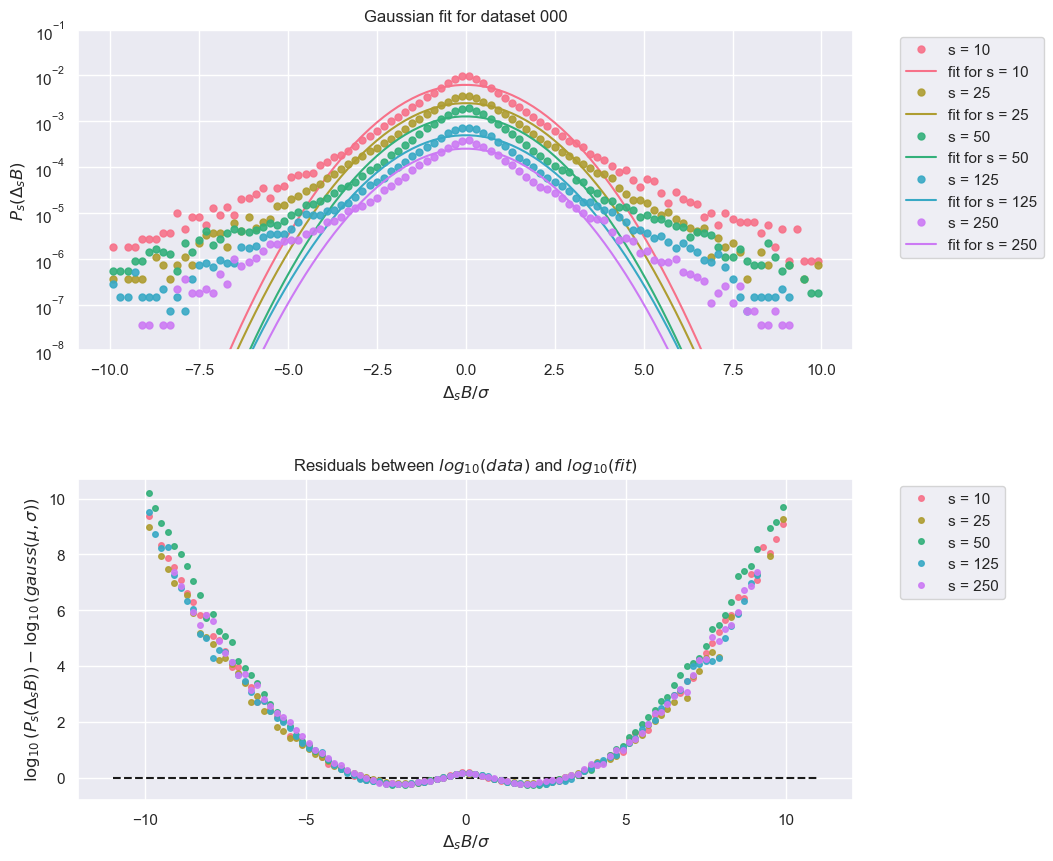

In [50]:
#to change
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import r2_score
from tqdm import tqdm
import sys

# Set style for the plots
sns.set(style="darkgrid")

# Initialize figure and axes with increased vertical spacing
fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})
ax[0].set_title("Gaussian fit for dataset 000")
ax[0].set_xlabel(r"$\Delta_s B / \sigma$")
ax[0].set_ylabel(r"$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(gauss(\mu, \sigma))$")
ax[1].set_xlabel(r"$\Delta_s B / \sigma$")
ax[1].hlines(0, -11, 11, linestyles="dashed", colors="k")

# Initialize the output table
table = {"s": [], "$R^2$": [], "RMSE": [], "NRMSE": []}

# Define different s values
s_list = [10, 25, 50, 125, 250]  # Different sample scales
colors = sns.color_palette("husl", len(s_list))  # Assign different colors for each s

"""# Disable tqdm output to suppress unwanted prints
sys.stdout = open('/dev/null', 'w')"""

for j, s in enumerate(tqdm(s_list)):
    # Load data (assuming 'data' and 'detr_and_standardize' are defined)
    df = detr_and_standardize(data, s_list)
    y = df.loc[s]
    y = y.dropna()  # Remove NaN values

    # Create histogram
    histo, bin_edges = np.histogram(y, bins=100, range=(-10, 10))
    bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit = bins_centers[bins_index_fit]
    histo_fit = histo[bins_index_fit]

    # Fit Gaussian distribution
    mu, sigma = norm.fit(y)
    y_fit = norm.pdf(bins_c_fit, mu, sigma)
    y_fit = y_fit / (s * np.sum(y_fit))

    # Plot histogram data
    histo_plot = histo_fit / (s * np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=5, alpha=0.9, label=f"s = {s}")
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")

    # Compute residuals and plot on second subplot
    residuals_log10 = np.log10(histo_plot) - np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=4, alpha=0.9, label=f"s = {s}")

    # Compute model evaluation metrics
    R2 = r2_score(histo_plot, y_fit)
    RMSE = np.sqrt(np.mean((histo_plot - y_fit) ** 2))
    NRMSE = RMSE / (np.max(histo_plot) - np.min(histo_plot))

    # Store results in the table
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)

# Re-enable standard output
sys.stdout = sys.__stdout__

# Add legends for both subplots
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Convert results to DataFrame and display
table = pd.DataFrame(table)
table.set_index('s', inplace=True)
print(table)

# Print final statement about fit quality
print("R2 values are all negatives, we therefore consider Gaussian function a really bad approximation of data.")
print("RMSE and NRMSE values are in agreement with R2 values.")

# Show the plots
plt.tight_layout()
plt.show()


**Key Observations:**


*   Around the center (0 on the x-axis), residuals are small, meaning the Gaussian approximation is good.

*   At both extremes (large positive/negative ΔsBΔs​B), residuals increase, meaning the Gaussian function underestimates the probability of extreme fluctuations.

*  The dashed black horizontal line at 0 indicates the ideal case where the fit perfectly matches the data.


## Castaing fit <a name="castaing"></a>
We fit the data to the following equation, based on the Castaing's function:

 $$\Pi (x) = \int_{0}^{+\infty} {\frac{1}{\sigma \sqrt{2\pi}}} exp(-\frac{x^2}{2\sigma^2}){\frac{1}{\lambda \sqrt{2\pi}} exp(- \frac{ln^2 (\sigma)}{2\lambda^2}) \frac{d\sigma}{\sigma}}$$



100%|██████████| 6/6 [00:21<00:00,  3.58s/it]
/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_2380/3652578172.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


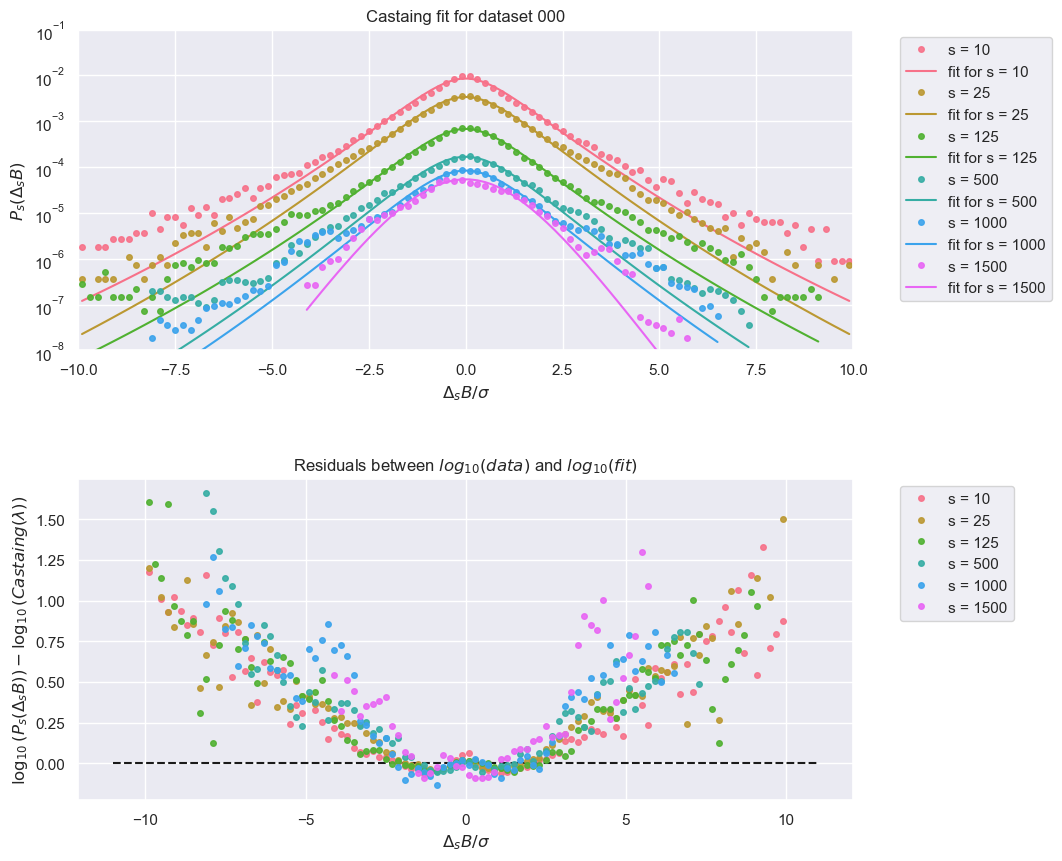

In [65]:
import scipy 
#to change!!!!
# Set style for the plots
sns.set(style="darkgrid")

# Histograms' parameters
n_bins = 100
hist_range = 10
marker_size = 4

# Initialize figure and axes with increased vertical spacing
fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})
ax[0].set_title("Castaing fit for dataset 000")
ax[0].set_xlabel(r"$\Delta_s B / \sigma$")
ax[0].set_ylabel(r"$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)
ax[0].set_xlim(-hist_range, hist_range)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel(r"$\Delta_s B / \sigma$")
ax[1].set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(Castaing(\lambda))$")
ax[1].hlines(0, -hist_range - 1, hist_range + 1, linestyles="dashed", colors="k")

# Initialize the output table
table = {"s": [], "$\lambda$": [], "$\sigma_{\lambda}$": [], "$R^2$": [], "RMSE": [], "NRMSE": []}

# Define different s values
s_list = [10, 25, 125, 500, 1000, 1500]  # Different sample scales
colors = sns.color_palette("husl", len(s_list))  # Assign different colors for each s

# Disable tqdm output to suppress unwanted prints
#sys.stdout = open('/dev/null', 'w')


def C_log10(x, lambd):
    c = Castaing_integral(x, lambd)
    return np.log10(c / np.trapz(c, x))


# Define the Castaing integral function
def Castaing_integral(x, lambd):

  result = scipy.integrate.quad(
        lambda sigma: 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma)**2/lambd**2) / 2),
    0, np.inf)
  return result[0]
Castaing_integral = np.vectorize(Castaing_integral)


for j, s in enumerate(tqdm(s_list)):
    # Load data (assuming 'data' and 'detr_and_standardize' are defined)
    df = detr_and_standardize(data, s_list)
    y = df.loc[s]
    y = y.dropna()  # Remove NaN values

    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit = bins_centers[bins_index_fit]
    histo_fit = histo[bins_index_fit]

    # This line was incorrectly indented
    histo_log = np.log10(histo_fit / np.sum(histo_fit))
    pars, pcov = curve_fit(f=C_log10, xdata=bins_c_fit, ydata=histo_log, p0=0.4, bounds=[0.1, 1])
    std = np.sqrt(pcov[0, 0])

    # Plot data
    histo_plot = histo_fit / (s * np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=marker_size, alpha=0.9, label=f"s = {s}")

    # Plot Fit
    y_fit = Castaing_integral(bins_c_fit, *pars)
    y_fit = y_fit / (s * np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")

    # Plot Residuals
    residuals_log10 = np.log10(histo_plot) - np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.9, label=f"s = {s}")

    # Compute model evaluation metrics
    R2 = r2_score(histo_plot, y_fit)
    RMSE = np.sqrt(np.mean((histo_plot - y_fit) ** 2))
    NRMSE = RMSE / (np.max(histo_plot) - np.min(histo_plot))

    # Store results in the table
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)
    table["$\lambda$"].append(pars[0])
    table["$\sigma_{\lambda}$"].append(std)

# Re-enable standard output
sys.stdout = sys.__stdout__

# Add legends for both subplots
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Convert results to DataFrame and display
table = pd.DataFrame(table)
table.set_index('s', inplace=True)
print(table)

# Print final statement about fit quality
print("We consider R2 scores good enough for Castaing fit.")
print("RMSE and NRMSE values are in agreement with R2 values.")

# Show the plots
plt.tight_layout()
plt.show()
